#### Section 1.4.1 Voltage Dividers
Taken from "Switch-Mode Power Supplies" by Christophe P. Basso

#### Imports

In [1]:
from pathlib import Path
import py4spice as spi
import copy

#### Path to Ngspice and the project

In [2]:
# Path to NGSPICE
NGSPICE_EXE = Path("/usr/bin/ngspice")

# Absolute path to my project
PROJ_PATH = Path("/workspaces/sw_pwr_book_sim/circuits/sec_1_04_02_lin_reg")

#### Prepare other paths

In [3]:
# Create sim_results directory if doesn't exist
RESULTS_PATH = PROJ_PATH / "sim_results"
RESULTS_PATH.mkdir(parents=True, exist_ok=True)

#### Define netlists

In [4]:
# Create netlists directory and files if they don't exist
NETLISTS_PATH = PROJ_PATH / "netlists"
NETLISTS_PATH.mkdir(parents=True, exist_ok=True)  # Create the directory

# Create title.cir with content only if it doesn't exist
TITLE_FILENAME = NETLISTS_PATH / "title.cir"
if not TITLE_FILENAME.exists():
    with open(TITLE_FILENAME, "w") as f:
        f.write("* First line in netlist must be a comment")
title = spi.Netlist(NETLISTS_PATH / TITLE_FILENAME)

# These netlist objects will be combined and a top netlist will be created later
dut = spi.Netlist(NETLISTS_PATH / "dut.cir")
load = spi.Netlist(NETLISTS_PATH / "load.cir")
stimulus = spi.Netlist(NETLISTS_PATH / "stimulus.cir")
supplies = spi.Netlist(NETLISTS_PATH / "supplies.cir")
models = spi.Netlist(NETLISTS_PATH / "models.cir")

# two files we'll create later
TOP_FILENAME = NETLISTS_PATH / "top.cir"
CONTROL_FILENAME = NETLISTS_PATH / "control.cir"

#### Convert easyeda_dut.cir to dut.cir
Note: copy netlist from EasyEDA and paste it into 'easyeda_dut.cir before execution

In [5]:
easyeda = spi.Netlist(NETLISTS_PATH / "easyeda_dut.cir")
easyeda.del_line_starts_with("*") # remove first line (comment)
easyeda.del_line_starts_with("veasyeda") # remove fake voltage source
easyeda.del_line_starts_with(".tran 1m 3.1415") # remove fake transient analysis
easyeda.del_line_starts_with(".inc standard.bjt") # remove model include
dut = easyeda
dut.write_to_file(NETLISTS_PATH / "dut.cir") # this is now the dut (device under test)

#### Create vectors

In [6]:
VEC_ALL = spi.Vectors("all")
VEC_ALL_EXPANDED = spi.Vectors(
    "q1_base div e1#branch in out out_meas vee vee#branch vin#branch vmeas#branch ref vref#branch"
)
VEC_OUT = spi.Vectors("out")
VEC_IN_OUT = spi.Vectors("in out")
VEC_INTEREST = spi.Vectors("in out div q1_base")
VEC_POWER_CALC = spi.Vectors("in vin#branch out vmeas#branch")
VEC_ETA = spi.Vectors("eta")

#### Define analyses

In [7]:
list_of_analyses: list[spi.Analyses] = [] # create empty list. Next sections define

# 1st analysis: operating point
# for this simulation, we'll have only one analysis
op_cmd = "op"
op1 = spi.Analyses("op1", "op", op_cmd, VEC_ALL, RESULTS_PATH)
list_of_analyses.append(op1)

# 2nd analysis
dc_cmd = "dc vin 6 17 0.1"
dc1 = spi.Analyses("dc1", "dc", dc_cmd, VEC_ALL, RESULTS_PATH)
list_of_analyses.append(dc1)

#### Create control section

In [8]:
my_control = spi.Control()  # create 'my_control' object
my_control.insert_lines(["listing"])  # cmd to list out netlist
for analysis in list_of_analyses:  # statements for all analyses
    my_control.insert_lines(analysis.lines_for_cntl())
my_control.content_to_file(CONTROL_FILENAME)  # creat the actual file
control = spi.Netlist(NETLISTS_PATH / CONTROL_FILENAME)  # create netlist object
spi.print_section("Control File", my_control)  # print out contents


--- Control File ---
.control
* Timestamp: Sun Feb 11 06:21:17 2024
set wr_singlescale  $ makes one x-axis for wrdata
set wr_vecnames     $ puts names at top of columns
listing
op
print line all > /workspaces/sw_pwr_book_sim/circuits/sec_1_04_02_lin_reg/sim_results/op1.txt
dc vin 6 17 0.1
wrdata /workspaces/sw_pwr_book_sim/circuits/sec_1_04_02_lin_reg/sim_results/dc1.txt all
quit
.endc
--------------------



#### Simulate

In [9]:
# Combine the netlists and write out into one top netlist, ready to simulate
top = title + dut + load + supplies + stimulus + models + control

top.write_to_file(TOP_FILENAME)
spi.print_section("top netlist", top)

# prepare simulate object, print out command, and simulate
sim1 = spi.Simulate(NGSPICE_EXE, TOP_FILENAME)
spi.print_section("Ngspice Command", sim1)
sim1.run() # run the Ngspice simulation


--- top netlist ---
* linear regulator
rupper div out 10k
rlower vee div 10k
e1 q1_base vee ref div 10k
q1 out q1_base in 2n2222

rload out out_meas 100
vmeas out_meas 0 dc 0
vee vee 0 dc 0
vref ref 0 dc 2.5
vin in 0 dc 12
.model 2n2222 npn bf=105 br=4 cjc=12.2p cje=35.5p ikf=.5
+ ikr=.225 is=15.2f ise=8.2p ne=2 nf=1 nr=1 rb=1.49 rc=.149
+ re=.373 tf=500p tr=85n vaf=98.5 var=20 xtb=1.5
.control
* timestamp: sun feb 11 06:21:17 2024
set wr_singlescale  $ makes one x-axis for wrdata
set wr_vecnames     $ puts names at top of columns
listing
op
print line all > /workspaces/sw_pwr_book_sim/circuits/sec_1_04_02_lin_reg/sim_results/op1.txt
dc vin 6 17 0.1
wrdata /workspaces/sw_pwr_book_sim/circuits/sec_1_04_02_lin_reg/sim_results/dc1.txt all
quit
.endc
-------------------


--- Ngspice Command ---
/usr/bin/ngspice -b /workspaces/sw_pwr_book_sim/circuits/sec_1_04_02_lin_reg/netlists/top.cir
-----------------------


Note: No compatibility mode selected!


Circuit: * linear regulator

	* line

Note: Starting dynamic gmin stepping
Trying gmin =   1.0000E-03 Note: One successful gmin step
Trying gmin =   1.0000E-04 Note: One successful gmin step
Trying gmin =   1.0000E-05 Note: One successful gmin step
Trying gmin =   1.0000E-06 Note: One successful gmin step
Trying gmin =   1.0000E-07 Note: One successful gmin step
Trying gmin =   1.0000E-08 Note: One successful gmin step
Trying gmin =   1.0000E-09 Note: One successful gmin step
Trying gmin =   1.0000E-10 Note: One successful gmin step
Trying gmin =   1.0000E-11 Note: One successful gmin step
Trying gmin =   1.0000E-12 Note: One successful gmin step
Trying gmin =   1.0000E-12 Note: One successful gmin step
Note: Dynamic gmin stepping completed


#### Simulation results to numpy

In [10]:
sim_results = [
    spi.SimResults.from_file(analysis.cmd_type, analysis.results_filename)
    for analysis in list_of_analyses
]

dup indexes are: [8]


#### Operating point values from op1 analysis

In [11]:
# 1st simulation was operating point
spi.print_section("Operating Point Results", sim_results[0].print_table())

0.0

--- Operating Point Results ---
div            2.499424
e1#branch     -0.00901033
in             12.0
out            4.998849
out_meas       0.0
q1_base        5.756765
ref            2.5
vee            0.0
vee#branch    -0.00876038
vin#branch    -0.0412281
vmeas#branch   0.04998849
vref#branch    0.0
-------------------------------



#### Results from DC transfer analysis

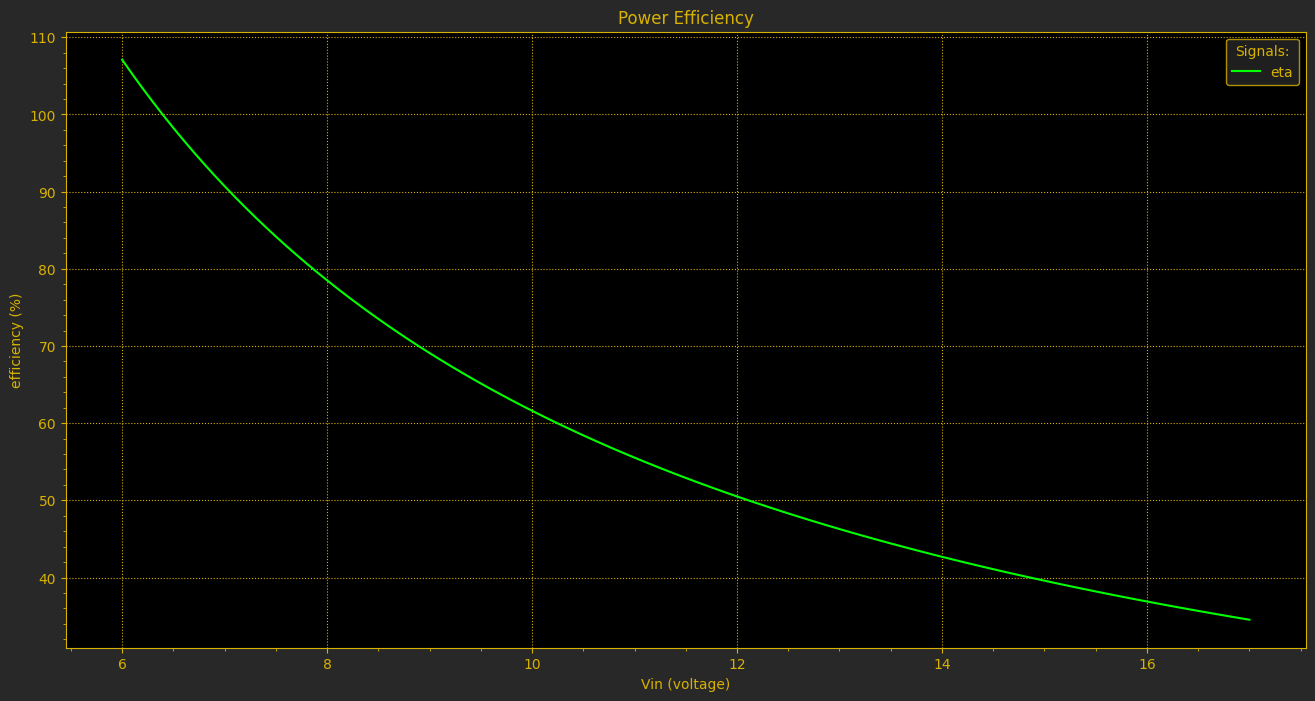

In [13]:
# make a copy of simresults[1] (dc analysis) and reduce signals necessary for power calc
pwr1 = copy.deepcopy(sim_results[1])
pwr1.vec_subset(VEC_POWER_CALC.list_out())
pwr1.multiply("in", "vin#branch", "pin")        # calc input power
pwr1.multiply("out", "vmeas#branch", "pout")    # calc output power
pwr1.divide("pout", "pin", "eta_neg")           # calc efficiency
pwr1.scaler(-100, "eta_neg", "eta")             # make positive value & convert to %

# make a copy and reduce signals to just "eta"
pwr2 = copy.deepcopy(pwr1)
pwr2.vec_subset(VEC_ETA.list_out())

# plot the efficiency vs. Vin
plot_data = pwr2.x_axis_and_sigs(VEC_ETA.list_out())
y_names = VEC_ETA.list_out()
my_plt = spi.Plot("my_plot", plot_data, y_names, RESULTS_PATH)
my_plt.set_title("Power Efficiency")
my_plt.define_axes(("Vin", "voltage", "linear"), ("efficiency", "%", "linear"))